In [155]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from IPython.display import Image
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import precision_recall_curve

In [2]:
data = pd.read_pickle('data.pkl')

In [3]:
# get rid of NaN values
pred_data = data[(data['channel'].notnull())&(data['country'].notnull())].copy()

# get dummies for categorical variables (I will use segment_article, channel_social media and country_MO as reference values)
cat_cols = pd.get_dummies(pred_data[['segment', 'channel', 'country']]).drop(['segment_article', 'channel_social media', 'country_MO'], 1)

# extract numerical columns
num_cols = pred_data[['clicks', 'latency']].copy()

# merge categorical and numerical columns and extarct target
final_pred = cat_cols.merge(num_cols, how='left', on='client_id')
X = final_pred.to_numpy()
target = pred_data['type'].apply(lambda x: 1 if x=='client' else 0)
y = target.to_numpy()

# record names for independet variables
col_names = list(final_pred.columns)



In [4]:
# fit logit model using statsmodels.api module to extract pvalues
sm_model = sm.Logit(y, sm.add_constant(X)).fit(disp=0)
print(sm_model.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               155893
Model:                          Logit   Df Residuals:                   155875
Method:                           MLE   Df Model:                           17
Date:                Fri, 22 Oct 2021   Pseudo R-squ.:                 0.03229
Time:                        11:14:01   Log-Likelihood:                -27995.
converged:                       True   LL-Null:                       -28929.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.1150      0.071    -72.053      0.000      -5.254      -4.976
x1             0.5770      0.026     22.307      0.000       0.526       0.628
x2             1.0405      0.068     15.299      0.0

As expected, most coefficients are positive: only three coefficients are negative, one of which is a constant. The remaining two are not significant. Now lets see which coefficients are significant.

In [5]:
# create a dataframe with independent variables names, pvalues of corresponding coefficients and signficance output at different confident levels
logit_coef = pd.DataFrame(col_names)
logit_coef['pvalue'] = sm_model.pvalues[1:]
logit_coef.columns = ['variable name', 'coef p-value']
logit_coef['90% conf level'] = logit_coef['coef p-value'].apply(lambda x: 'sign' if x<0.1 else 'not sign')
logit_coef['95% conf level'] = logit_coef['coef p-value'].apply(lambda x: 'sign' if x<0.05 else 'not sign')
logit_coef['99% conf level'] = logit_coef['coef p-value'].apply(lambda x: 'sign' if x<0.01 else 'not sign')

# print the results
print(logit_coef)

        variable name   coef p-value 90% conf level 95% conf level  \
0    segment_telegram  3.146263e-110           sign           sign   
1   channel_affiliate   7.728641e-53           sign           sign   
2      channel_direct   5.911719e-58           sign           sign   
3    channel_facebook  6.333765e-119           sign           sign   
4         channel_smm  1.125791e-129           sign           sign   
5          country_DE   1.236042e-01       not sign       not sign   
6          country_ES   2.875714e-01       not sign       not sign   
7          country_FR   9.115639e-01       not sign       not sign   
8          country_IN   1.184672e-01       not sign       not sign   
9          country_IS   5.385576e-02           sign       not sign   
10         country_IT   4.102628e-01       not sign       not sign   
11         country_LT   4.081624e-01       not sign       not sign   
12         country_LU   4.630045e-01       not sign       not sign   
13         country_U

Remember that we used segment_article, channel_social media and country_MO as reference variables in logistic regression. For example, for segment group channel_telegram coefficient is significant at all levels implying that difference in probabilty of making a deposit between users that come from telegram and article is significant. In fact, as the coefficient is positive the probabilty of making a deposit is higher in telegram than in article group.

The same logic is applicable to channel group: the probability of making a deposit is significantly higher in all channels relative to social media channel. As for countries, only coefficient behind country_IS is significant at 90% level (by the way, IS is the country with the highest conversion rate). Generally, one can conlude that probability of making a depsoit across countries does not statistcally differ. Finally, the coefficient behind latency is positive and significant at all levels, which is new information. The practical interpretation is quite tricky: the more time appliccation is loading, the higher is probability a user will make a deposit.

All in all, the results of logistic regression application are in line with the previous study of conversion rates across different groups. This is not surprising since conversion rate is a way to proxy probability of making a deposit. Previously, we found that conversion rates across segments statistically differ. We also found that social media channel has the lowest conversion rate in channel group. Finally, we showed that there is no evidence of conversion rate difference between countries. Logistic regression results confirmed these findings, though in a slightly different way.

In [ ]:
# create function to plot confusion matrix
def conf_matrix(y_train, pred_train):
    """"Returns a plot of confusion matrix"""
    
    # creating a confusion matrix
    con_mat = confusion_matrix(y_train, pred_train)
    con_mat = pd.DataFrame(con_mat, range(2), range(2))
   
    # ploting the confusion matrix
    plt.figure(figsize=(6,6))
    sns.set(font_scale=1.5) 
    sns.heatmap(con_mat, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')

In [132]:
# create function to calculate classification scores
def calculate_score(y_train, pred_train):
    """"Reurns accuracy, precision, recall and f1 scores for sample binary vavriable values and predicted values"""
    
    accuracy = accuracy_score(y_train, pred_train)
    print('Accuracy is {:.3f}.'.format(accuracy))
    precision = precision_score(y_train, pred_train, zero_division=0)
    print('Precision is {:.3f}.'.format(precision))
    recall = recall_score(y_train, pred_train)
    print('Recall is {:.3f}.'.format(recall))
    f1 = f1_score(y_train, pred_train)
    print('F1 score is {:.3f}.'.format(f1))

In [163]:
# create function to plot PR curve
def plot_precision_vs_recall(precisions, recalls):
    """"Returns PR plot"""
    
    sns.set_style('whitegrid')
    plt.figure(figsize=(8, 6))
    plt.plot(recalls, precisions, linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.title('PR Curve')
    plt.show()

In [41]:
# devide the whole data into train and test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# apply feature scaling (standard scaling) to numerical columns (these are last two rows, i.e. clikcs and latency)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X[:, -2:])
X_train[:, -2:] = scaler.fit_transform(X_train[:, -2:])
X_test[:, -2:] = scaler.fit_transform(X_test[:, -2:])

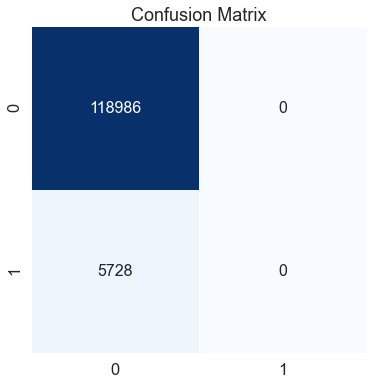

In [117]:
# fit logistic regression to the train data and record the predicted values
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
pred_train = log_reg.predict(X_train)

# plot confusion matrix 
conf_matrix(y_train, pred_train)

In [134]:
# calculate classification scores
calculate_score(y_train, pred_train)

Accuracy is 0.954.
Precision is 0.000.
Recall is 0.000.
F1 score is 0.000.


The algorithm predicted that all usres are leads. This is due to the unbalanced dependent variable, i.e. user type. In the initial dataset only 4% of users are clients and the most machine learning algorithms do not account for that fact by default. 

A loss function for default linear regression is shown below. Since the number of leads in the dataset is overwhelming majority, the loss function optimization will be primarly focused on this majority. What we need is to assign weights inside the loss function, so the minority class influneces the optimization as well.

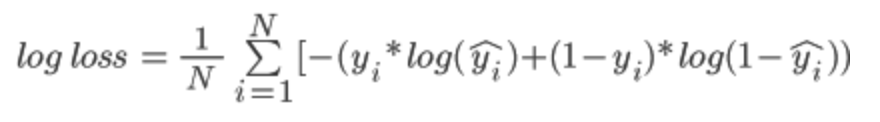

In [140]:
# show default loss function
Image("initial_lf.png")

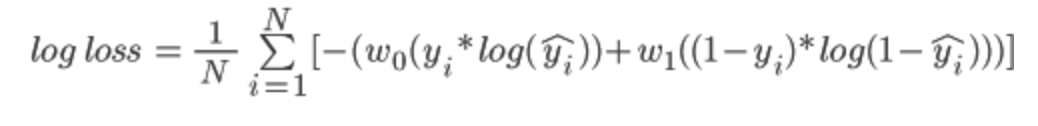

In [139]:
# show class weighted loss function
Image("weighted_lf.png")

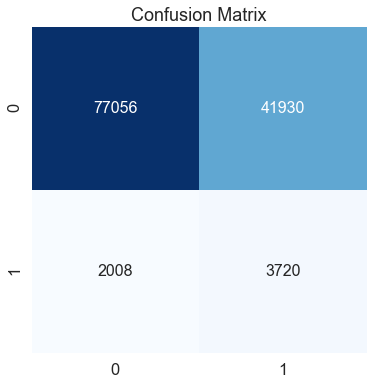

In [141]:
# fit logistic regression with class weighted loss function to the train data and record the predicted values
log_reg = LogisticRegression(class_weight='balanced')
log_reg.fit(X_train, y_train)
pred_train = log_reg.predict(X_train)

# plot confusion matrix 
conf_matrix(y_train, pred_train)

In [142]:
# calculate classification scores
calculate_score(y_train, pred_train)

Accuracy is 0.648.
Precision is 0.081.
Recall is 0.649.
F1 score is 0.145.


Now results are better, but not perfect: approximately 65% of clients are identified by the model (reccall score), but at the same time a significant number of leads are predicted to be clients, which results in low precision score.

Lets try to search for the weights that give the highets f1 score, which is a combination of recall and precision.

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.6min finished
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Scoring for different class weights')

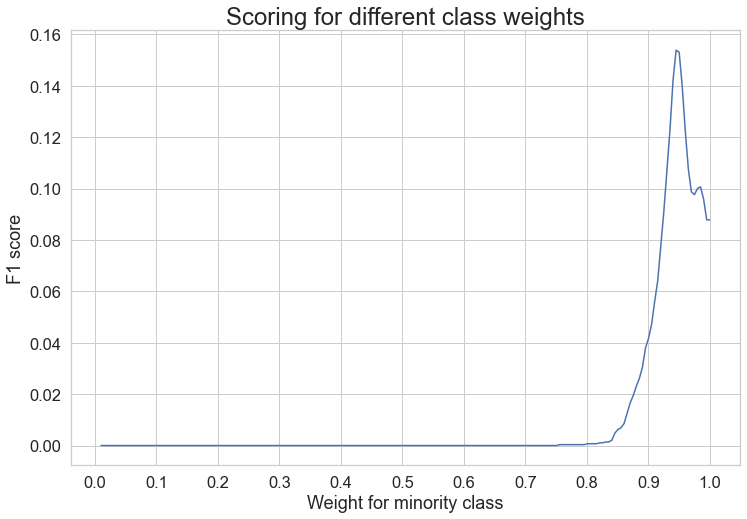

In [147]:
# initialize logistic regression
log_reg = LogisticRegression()

#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= log_reg, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train, y_train)

#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for minority class')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)

The graph shows that the highest f1 score (about 15%) is achieved at minority class wheight about 0.95.

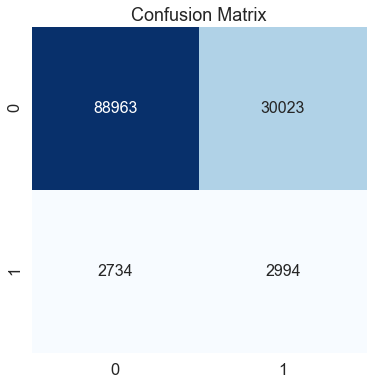

In [151]:
# extract weight for minority class which produces the highest f1 score
minor_w = weigh_data.sort_values('score', ascending=False).iloc[0,1]

# fit linear regression with manual weights to the train data
log_reg = LogisticRegression(class_weight={0: 1-minor_w, 1: minor_w})
log_reg.fit(X_train, y_train)
pred_train = log_reg.predict(X_train)

# plot confusion matrix for train data
conf_matrix(y_train, pred_train)

In [152]:
# calculate classification scores for train data
calculate_score(y_train, pred_train)

Accuracy is 0.737.
Precision is 0.091.
Recall is 0.523.
F1 score is 0.155.


We achieved a slight increase in f1 score relative to the previous result. If one is more interested in recall score (which might be the case since one would want the model to identify all clients correcltly at the cost of predicting more leads as clients), one can look at the PR curve and identify the desired threshold. However, I will not proceed with this here and will only plot the PR curve.

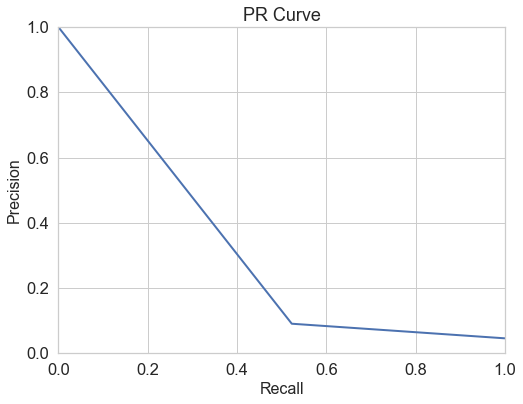

In [165]:
# record precisions, recalls, thresholds form the train data
precisions, recalls, thresholds = precision_recall_curve(y_train, pred_train)

# plot PR curve for train data
plot_precision_vs_recall(precisions, recalls)

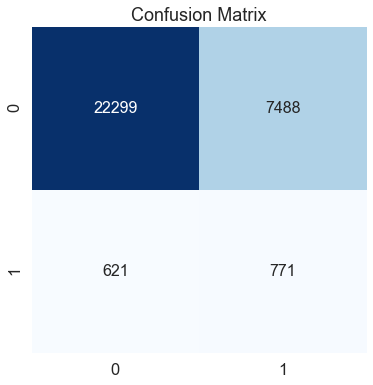

In [153]:
# get predicted values for test data
pred_test = log_reg.predict(X_test)

# plot confusion matrix for test data
conf_matrix(y_test, pred_test)

In [154]:
# calculate classification scores for test data
calculate_score(y_test, pred_test)

Accuracy is 0.740.
Precision is 0.093.
Recall is 0.554.
F1 score is 0.160.


On the test data the model performs even better than on the train data with regard to metrics above. All in all, however, the perfomance of the final model is not very good in general terms. It might be connected to unbalanced nature of dependent variable, low explanatory power of independent variables. One can try to improve it by dropping some features or picking up a more complex model. 